(lgm-intro-notebook)=
# Curve di crescita latente 

In [1]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
    library("JWileymisc")
    library("multilevelTools")
    library("data.table")
})

set.seed(12345)

ERROR: Error in library("patchwork"): there is no package called ‘patchwork’


Negli ultimi decenni, il framework SEM è stato esteso per adattarsi ai dati longitudinali e alle misure ripetute (McArdle, 2009). A differenza delle tecniche tradizionali come l’ANOVA a misure ripetute, che spesso non tengono conto della complessa struttura degli errori dei dati longitudinali, il framework SEM longitudinale consente di descrivere tale complessità. Questo approccio è strettamente associato ai modelli misti (Bernal-Rusiel et al., 2013; Rovine e Molenaar, 2001) e può essere considerato come un caso generale di cui molte procedure statistiche come i test t di Student, la regressione lineare e le analisi per misure ripetute di tipo (M)ANOVA sono casi speciali (Voelkle, 2007). Esempi di SEM longitudinale includono i growth curve models, i latent change score models, i growth mixture models, i latent class growth curve modelling e i continuous time models (Driver et al., 2016; McArdle, 2009).

Una classe importante di modelli SEM longitudinali sono i latent growth models (LGM), utilizzati per analizzare i dati longitudinali in cui una misura di esito viene raccolta in diversi momenti nel tempo per studiare il cambiamento nel tempo.

{cite:t}`grimm2016growth` elencano cinque motivi per usare i modelli LGM.

1. L’identificazione diretta del cambiamento e della stabilità intra-individuale. Misurando lo stesso individuo ripetutamente, i ricercatori possono identificare se e come specifici attributi dell’individuo cambiano o rimangono gli stessi nel tempo. Le teorie dello sviluppo spesso descrivono il cambiamento come un processo incrementale o trasformazionale. Il cambiamento incrementale viene identificato come un cambiamento nella grandezza di un costrutto lungo un continuum durante un intervallo di tempo specifico. Il cambiamento trasformazionale viene identificato come una transizione tra stati discreti durante un intervallo di tempo specifico (ad esempio, la teoria dello sviluppo a stadi di Piaget; Piaget, 1952). L’obiettivo principale è ottenere una descrizione accurata e parsimoniosa di come e quando gli attributi dell’individuo cambiano nel tempo. La stabilità e la costanza nel tempo sono casi speciali di cambiamento intra-individuale.
2. Una volta identificato il modello di cambiamento intra-individuale, una domanda logica successiva è se diversi individui cambiano in modi diversi. Pertanto, il secondo motivo per la ricerca longitudinale è l’identificazione delle differenze interindividuali nel cambiamento intra-individuale. Ci si chiede se i diversi individui cambino in quantità o direzioni diverse o se passino da uno stadio all’altro in momenti diversi.
3. Il terzo motivo per la ricerca longitudinale è l’analisi delle interrelazioni nel cambiamento comportamentale. Questo approccio si basa sull’idea che ci sono cambiamenti simultanei e/o sequenziali in più costrutti. L’analisi richiede l’analisi simultanea di più variabili e la valutazione di come i cambiamenti in una variabile influenzino i cambiamenti in un’altra variabile.
4. Il quarto motivo è l’analisi delle cause del cambiamento intra-individuale. L’obiettivo è identificare i fattori e/o i meccanismi variabili nel tempo che influenzano i cambiamenti intra-individuali. Si assume che i cambiamenti procedano a ritmi diversi in periodi di tempo diversi.
5. Il quinto motivo per la ricerca longitudinale è l’analisi delle cause delle differenze interindividuali nel cambiamento intra-individuale. Poiché gli individui differiscono nel modo in cui cambiano nel tempo, i ricercatori sono interessati a identificare i fattori che possono spiegare queste differenze. L’obiettivo è identificare le variabili invarianti nel tempo che sono correlate a specifici aspetti del cambiamento all’interno della persona. Ad esempio, le caratteristiche demografiche, gli interventi sperimentali e le caratteristiche dei contesti degli individui possono influenzare come e quando il cambiamento avviene. Le domande di ricerca derivanti dal quinto motivo sono spesso esaminate attraverso l’inclusione di covariate invarianti nel tempo.

## Preliminari

I modelli di crescita sono applicati a dati ottenuti da studi in cui sono state ottenute diverse misure ripetute da più individui. Un problema comune nella ricerca psicologica è lo studio di come le persone differiscono nei loro sentimenti, pensieri e comportamenti nel tempo e nello spazio. L’obiettivo è capire se queste differenze sono sistematiche e come descriverle al meglio. 

Tradizionalmente, gli studi longitudinali erano progettati in modo tale che il numero di valutazioni ripetute fosse relativamente basso (cioè <8) e il numero di individui fosse relativamente elevato (cioè >200). Tuttavia, i progressi sia nelle considerazioni teoriche del cambiamento (ad esempio, la non linearità) sia nella tecnologia per la raccolta dei dati (ad esempio, sondaggi basati sul web, smartphone) hanno notevolmente ampliato le possibilità di raccolta e analisi dei dati longitudinali: {cite:t}`grimm2016growth` discutono applicazioni di modelli di crescita a dati longitudinali ottenuti fino a 50.000 persone e fino a 1.000 valutazioni ripetute.

### Strutture dei dati

I dati longitudinali tipicamente si presentano in due forme: long e wide. Nel formato long, la descrizione del tempo è sulle righe; nel formato wide le variabili relative ad ogni occasione temporale sono organizzate in colonne. È possibile trasformere i dati dal formato long in formato wide e viceversa usando le funzioni R `pivot_wider()` e `pivot_longer()`. La sintassi è spiegata nella pagina web [tidyr](https://tidyr.tidyverse.org/reference/pivot_wider.html).

### Visualizzazione dei dati longitudinali

Come in qualsiasi analisi statistica, è importante esaminare attentamente i dati. Ciò include la produzione di sia riepiloghi quantitativi che visualizzazioni. 

Per fare un esempio di visualizzazione di dati longitudinali, esaminiamo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA [i dati sono presentati nel capitolo 3 del libro di {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# view the first few observations in the data set
head(nlsy_math_long)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,38,3,2,111,0,1,0
2,201,1,0,0,55,5,3,135,1,1,0
3,303,1,0,1,26,2,2,121,0,1,2
4,303,1,0,1,33,5,3,145,0,1,2
5,2702,0,0,0,56,2,2,100,NA,1,0
6,2702,0,0,0,58,4,3,125,NA,1,2


Le traiettorie di cambiamento intra-individuale possono essere prodotte nel modo seguente.

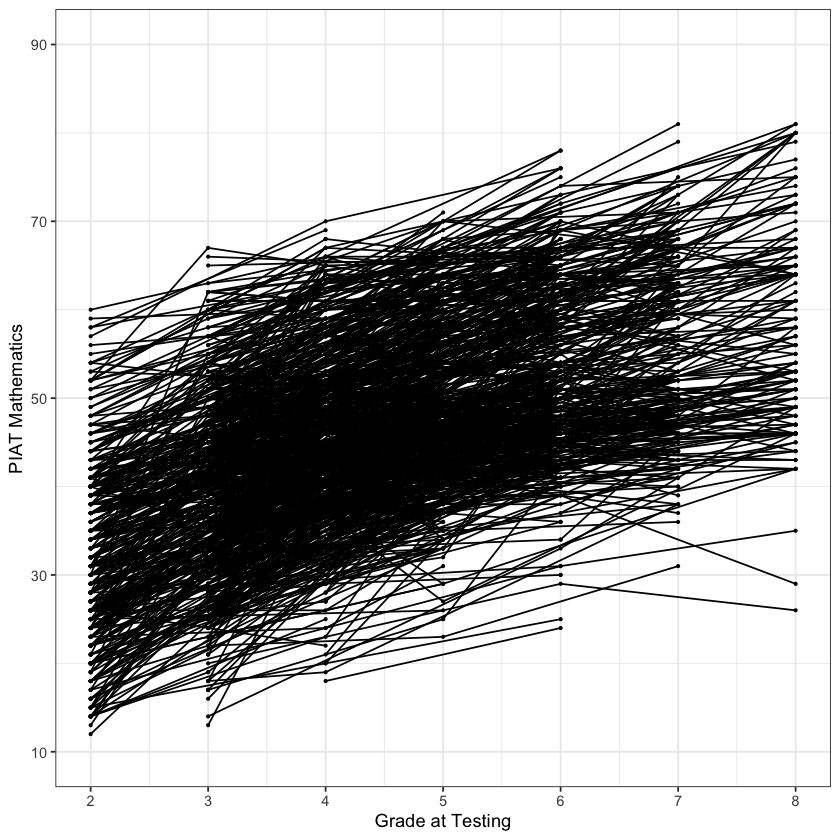

In [3]:
nlsy_math_long |> # data set
  ggplot(aes(x = grade, y = math, group = id)) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

### Data screening

Prima di adattare i modelli di crescita, è importante esaminare i dati e ottenere informazioni di base sulle variabili da utilizzare nell’analisi. La selezione preliminare dovrebbe includere l'esame della distribuzione dei punteggi per ogni variabile. Come al solito, le principali statistiche descrittive univariate includono la media, la mediana, la varianza (deviazione standard), l’asimmetria, la curtosi, il minimo, il massimo, l’intervallo e il numero di osservazioni per ogni variabile in base alla metrica del tempo scelta. Le statistiche descrittive bivariate includono correlazioni/covarianze e tabelle di frequenza bivariate per variabili nominali o ordinali. Tutte queste statistiche possono essere esaminate per individuare schemi e relazioni non lineari, così come potenziali valori anomali e codici errati. 

I dati longitudinali sono speciali perché sono ordinati, il che può essere indicizzato lungo una o più metriche del tempo (variabili come occasione di misurazione, età, data, tempo dall’evento, numero di esposizioni, ecc.). Ad esempio, è immediatamente informativo esaminare come la media, la varianza e il numero di casi disponibili cambiano attraverso le misure ripetute (ad esempio wght5, wght6, wght7). Si noti che la selezione della metrica del tempo influenza notevolmente come i risultati di qualsiasi modello di crescita specifico possono essere interpretati. Pertanto, nella fase di selezione dei dati è importante considerare come varie proprietà dei dati longitudinali differiscano quando i dati sono organizzati in relazione a diverse metriche del tempo. 

Per i dati dell'esempio, le statistiche descrittive possono essere ottenute nel modo seguente.

In [4]:
describe(nlsy_math_long)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id,1,2221,5.284491e+05,3.273037e+05,497403,5.154669e+05,384144.6252,201,1256601,1256400,0.30258128,-0.8968290,6.945070e+03
female,2,2221,4.934714e-01,5.000700e-01,0,4.918402e-01,0.0000,0,1,1,0.02609895,-2.0002188,1.061100e-02
lb_wght,3,2221,7.969383e-02,2.708796e-01,0,0.000000e+00,0.0000,0,1,1,3.10187193,7.6250432,5.747805e-03
anti_k1,4,2221,1.416929e+00,1.497133e+00,1,1.194147e+00,1.4826,0,8,8,1.14091473,1.1448077,3.176772e-02
math,5,2221,4.611977e+01,1.279992e+01,46,4.621666e+01,11.8608,12,81,69,-0.03406619,-0.1808447,2.716020e-01
grade,6,2221,4.512382e+00,1.769220e+00,4,4.435566e+00,1.4826,2,8,6,0.25689681,-0.9232006,3.754115e-02
occ,7,2221,2.841063e+00,7.886855e-01,3,2.774902e+00,1.4826,2,5,3,0.54731500,-0.4754854,1.673515e-02
age,8,2221,1.269032e+02,2.206059e+01,126,1.262802e+02,25.2042,82,175,93,0.18672163,-0.9115950,4.681044e-01
men,9,1074,1.945996e-01,3.960766e-01,0,1.186047e-01,0.0000,0,1,1,1.54069191,0.3740825,1.208585e-02


Esaminiamo le statistiche descrittive bivariate.

In [5]:
cor(nlsy_math_long, use='pairwise.complete.obs') |> 
  round(2)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
id,1.00,-0.01,-0.01,-0.02,-0.22,-0.01,0.01,-0.01,-0.02,-0.11,0.01
female,-0.01,1.00,0.06,-0.09,-0.05,0.00,-0.02,-0.04,0.02,0.04,-0.07
lb_wght,-0.01,0.06,1.00,0.03,-0.03,-0.02,-0.03,0.01,0.04,0.03,0.02
anti_k1,-0.02,-0.09,0.03,1.00,-0.08,-0.03,-0.04,-0.01,0.01,-0.01,0.52
math,-0.22,-0.05,-0.03,-0.08,1.00,0.59,0.53,0.58,0.30,0.29,-0.05
grade,-0.01,0.00,-0.02,-0.03,0.59,1.00,0.87,0.95,0.62,0.12,0.04
occ,0.01,-0.02,-0.03,-0.04,0.53,0.87,1.00,0.86,0.57,0.17,0.04
age,-0.01,-0.04,0.01,-0.01,0.58,0.95,0.86,1.00,0.64,0.21,0.06
men,-0.02,0.02,0.04,0.01,0.30,0.62,0.57,0.64,1.00,0.16,0.13
spring,-0.11,0.04,0.03,-0.01,0.29,0.12,0.17,0.21,0.16,1.00,-0.01


In [ ]:
tmp <- meanDecompose(math ~ id, data = nlsy_math_long)
glimpse(tmp)

In [ ]:
plot(
    testDistribution(
        tmp[["math by id"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Between Person Math Scores"
)

In [ ]:
plot(
    testDistribution(
        tmp[["math by residual"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Within Person Math Scores"
)

### Attendibilità

Come in tutte le analisi, i ricercatori dovrebbero esaminare l’affidabilità dei loro strumenti di misurazione.

In [6]:
nlsy_math_only_long <- nlsy_math_long %>%
    dplyr::select(id, grade, math)

In [7]:
iccMixed(
  dv = "math",
  id = "id",
  data = nlsy_math_long
)

Var,Sigma,ICC
<chr>,<dbl>,<dbl>
id,47.02036,0.2872289
Residual,116.68307,0.7127711


### Analisi con `lmer`

In [20]:
m <- lmer(math ~ grade + (1 + grade | id), data = nlsy_math_long)

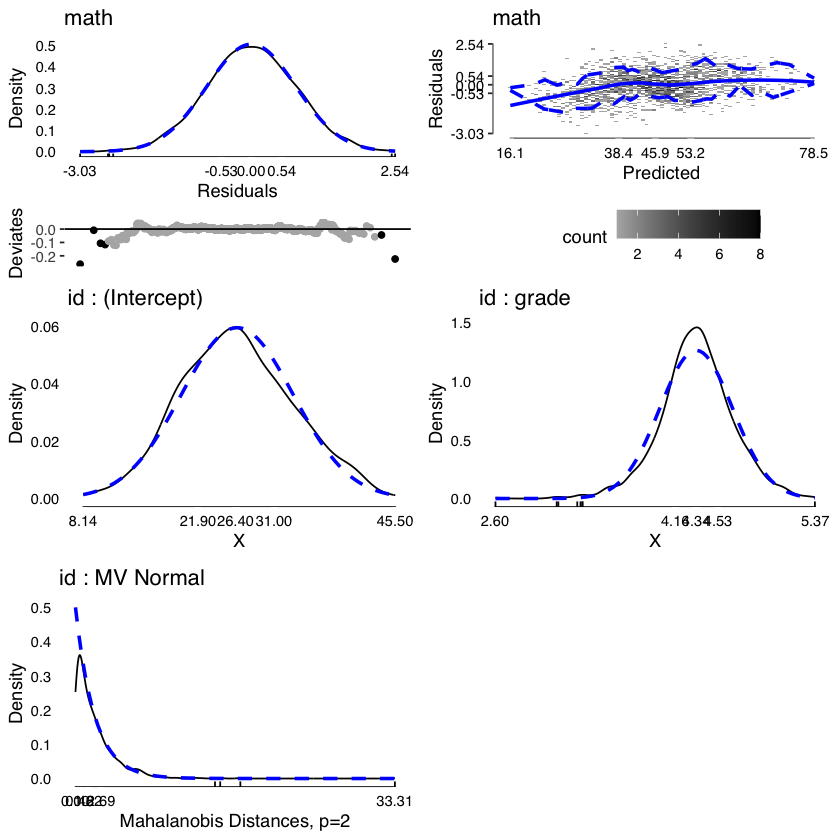

In [21]:
md <- modelDiagnostics(m, ev.perc = .001)
plot(md, ask = FALSE, ncol = 2, nrow = 3)

In [22]:
mvextreme <- subset(
  md$extremeValues,
  EffectType == "Multivariate Random Effect UserID"
)

head(mvextreme)
unique(mvextreme$UserID)

math,id,Index,EffectType
<int>,<int>,<int>,<chr>


NULL

In [25]:
out = summary(m)
print(out)

Linear mixed model fit by REML ['lmerMod']
Formula: math ~ grade + (1 + grade | id)
   Data: nlsy_math_long

REML criterion at convergence: 15941

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.02728 -0.52567  0.00174  0.54025  2.54129 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 68.4055  8.2708        
          grade        0.7392  0.8597   -0.24
 Residual             36.2364  6.0197        
Number of obs: 2221, groups:  id, 932

Fixed effects:
            Estimate Std. Error t value
(Intercept) 26.58805    0.47203   56.33
grade        4.33956    0.08741   49.65

Correlation of Fixed Effects:
      (Intr)
grade -0.771


In [32]:
ranef(m)$id[1:5, ]

,(Intercept),grade
,<dbl>,<dbl>
201,1.284771,0.1960644
303,-8.654039,-0.2892441
2702,13.929647,0.2542062
4303,5.355823,0.2094322
5002,1.425426,0.1581868


In [23]:
modelPerformance(m)

$Performance
    Model Estimator N_Obs N_Groups      AIC      BIC        LL LLDF   Sigma
1: merMod      REML  2221 id (932) 15952.99 15987.22 -7970.494    6 6.01967
   MarginalR2 ConditionalR2 MarginalF2 ConditionalF2
1:  0.3553142      0.781476  0.5511433      3.576157

attr(,"class")
[1] "modelPerformance.merMod" "modelPerformance"       

In [24]:
mt <- modelTest(m)
names(mt)
APAStyler(mt)

Parameters and CIs are based on REML, 
but modelTests requires ML not REML fit for comparisons, 
and these are used in effect sizes. Refitting.



[1] "FixedEffects"  "RandomEffects" "EffectSizes"   "OverallModel"

Term,Est,Type
<chr>,<chr>,<chr>
(Intercept),"26.59*** [25.66, 27.51]",Fixed Effects
grade,"4.34*** [ 4.17, 4.51]",Fixed Effects
cor_grade.(Intercept)|id,-0.24,Random Effects
sd_(Intercept)|id,8.27,Random Effects
sd_grade|id,0.86,Random Effects
sigma,6.02,Random Effects
Model DF,6,Overall Model
N (Groups),id (932),Overall Model
N (Observations),2221,Overall Model


### Invarianza di misurazione

Quando si lavora con dati di misure ripetute, la comparabilità dei punteggi tra le occasioni di misurazione richiede un certo livello di invarianza di misurazione. Lo strumento di misurazione misura lo stesso costrutto nella stessa metrica in ogni occasione? Formalmente, l’invarianza di misurazione garantisce che i punteggi siano confrontabili sia tra le persone che tra le occasioni di misurazione. Ad esempio, l’invarianza di misurazione tra le misure ripetute del peso degli individui è facilitata dall’uso dello stesso dispositivo di misurazione (bilancia) ogni anno, a condizione che la bilancia sia tarata nello stesso modo ogni anno. Se la bilancia è tarata in modo diverso in occasioni diverse o se vengono utilizzate unità di misura diverse, i punteggi risultanti non possono essere confrontati quantitativamente: lo strumento di misurazione è non invariante. Quando si lavora con dispositivi fisici, l’invarianza di misurazione viene testata e garantita attraverso la taratura. Quando si lavora con scale psicologiche, l’invarianza di misurazione viene o assunta (il che non ideale) o testata utilizzando modelli di misurazione formali.



